# LSTM/GRU_Classifier

## Import useful libraries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import string
import re
import nltk
import pickle
import time
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from gensim.utils import simple_preprocess
from gensim import corpora
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import recall_score,f1_score,precision_score,classification_report,roc_curve,auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score
from torchtext import data
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Load Prepared-Cleaned Datasets.

In [ ]:
# Load GloVe vectorized Χ_train.
x_train_file = open('/content/drive/My Drive/AI(II)/prepared_datasets/X_train.pkl', 'rb')
X_train = pickle.load(x_train_file)
x_train_file.close()
  
# Load GloVe vectorized Χ_val.
x_val_file = open('/content/drive/My Drive/AI(II)/prepared_datasets/X_val.pkl', 'rb')
X_val = pickle.load(x_val_file)
x_val_file.close()

# Load GloVe vectorized Χ_test.
x_test_file = open('/content/drive/My Drive/AI(II)/prepared_datasets/X_test.pkl', 'rb')
X_test = pickle.load(x_test_file)
x_test_file.close()

# Load Y_train.
y_train_file = open('/content/drive/My Drive/AI(II)/prepared_datasets/Y_train.pkl', 'rb')
Y_train = pickle.load(y_train_file)
y_train_file.close()

# Load Y_val.
y_val_file = open('/content/drive/My Drive/AI(II)/prepared_datasets/Y_val.pkl', 'rb')
Y_val = pickle.load(y_val_file)
y_val_file.close()

# Load Y_test.
y_test_file = open('/content/drive/My Drive/AI(II)/prepared_datasets/Y_test.pkl', 'rb')
Y_test = pickle.load(y_test_file)
y_test_file.close()

print("X_train's shape:", X_train.shape)
print("X_val's shape:", X_val.shape)
print("X_test's shape:", X_test.shape,"\n")
print("Y_train's shape:", Y_train.shape)
print("Y_val's shape:", Y_val.shape)
print("Y_test's shape:", Y_test.shape)

X_train's shape: (495012, 1)
X_val's shape: (2488, 1)
X_test's shape: (2500, 1) 

Y_train's shape: (495012, 1)
Y_val's shape: (2488, 1)
Y_test's shape: (2500, 1)


## Concatenation of tweets with labels.

In [ ]:
train = pd.concat([X_train, Y_train], axis=1)
print(train.shape)

valid = pd.concat([X_val, Y_val], axis=1)
print(valid.shape)

test = pd.concat([X_test, Y_test], axis=1)
print(test.shape)

(495012, 2)
(2488, 2)
(2500, 2)


## Let's check ratio of negative-positive sentiments in our tweets.

In [ ]:
train.target.value_counts()

1    248360
0    246652
Name: target, dtype: int64

In [ ]:
valid.target.value_counts()

0    1267
1    1221
Name: target, dtype: int64

In [ ]:
test.target.value_counts()

0    1281
1    1219
Name: target, dtype: int64

## Save our datasets as .csv files.

In [ ]:
train.to_csv("/content/drive/My Drive/AI(II)/prepared_datasets/train.csv", index=False)
test.to_csv("/content/drive/My Drive/AI(II)/prepared_datasets/test.csv", index=False)
valid.to_csv("/content/drive/My Drive/AI(II)/prepared_datasets/valid.csv", index=False)

## Create TEXT,LABEL from torchtext.data

In [ ]:
TEXT = data.Field(dtype=torch.long,sequential=True, tokenize="spacy",batch_first=True)
LABEL = data.LabelField(dtype=torch.long, sequential=False)

## Loading train, test and validation set. 


In [ ]:
train_data, valid_data, test_data = data.TabularDataset.splits( 
    path="/content/drive/My Drive/AI(II)/prepared_datasets/", 
    train="train.csv", 
    validation="valid.csv", 
    test="test.csv",
    format="csv", 
    skip_header=True, 
    fields=[('Text', TEXT), ('Label', LABEL)])

print(f'Number of training examples: {len(train_data)}')
print(f'Number of valid examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 495012
Number of valid examples: 2488
Number of testing examples: 2500


## Build Vocabulary

In [ ]:
TEXT.build_vocab(train_data, vectors=torchtext.vocab.Vectors("/content/drive/MyDrive/AI(II)/glove_models/glove.6B.50d.txt"),max_size=20000,min_freq=5)
LABEL.build_vocab(train_data)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 20002
Unique tokens in LABEL vocabulary: 2


## Prepare GPU Cuda.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


## Bucket Iterators

In [ ]:
BATCH_SIZE = 512

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort_key=lambda x: len(x.Text),
    batch_size=BATCH_SIZE,
    shuffle=True,
    device=device)

## Implementation of class RNN


In [ ]:
class LSTM_GRU(nn.Module):
  """
  The LSTM/GRU model that will be used to perform Tweet Sentiment Analysis.
  """

  def __init__(self, cell_type, input_size, embedding_size, hidden_size, output_size, embeddings, num_layers, bidirectional, dropout_prob):
    """
    Initialize the model by setting up the layers.
    """
    super(LSTM_GRU, self).__init__()

    cells = {
    "LSTM"    : nn.LSTM,
    "GRU"     : nn.GRU
    }   

    # Initializations
    self.cell_type = cell_type
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.output_size = output_size
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.dropout_prob = dropout_prob
    self.hidden_size = hidden_size
      
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.embedding.weight = torch.nn.Parameter(embeddings, requires_grad=False)

    self.nn = cells[cell_type](          # Pick the specific model
        input_size=self.embedding_size,   # Number of features for each time step
        hidden_size=self.hidden_size,     # LSTM/GRU hidden embedding representation
        num_layers=self.num_layers,       # Number of layers (if >1 it is a stacked RNN)
        bidirectional=self.bidirectional, # If true we have bidirectional 
        batch_first=True,                 # input & output will have batch size as 1st dimension. e.g. (batch, time_step, input_size)
        dropout=self.dropout_prob         # dropout prob >= 0.0
    )
    
    # Dropout layer
    if self.dropout_prob > 0.0: 
      self.dropout = nn.Dropout(self.dropout_prob)
    
    # Linear layer
    if self.bidirectional: 
      self.linear = nn.Linear(self.hidden_size*2,self.output_size)
    else:
      self.linear = nn.Linear(self.hidden_size,self.output_size)

    # Sigmoid output layer
    self.sig = nn.Sigmoid()
      
  def forward(self, x, hidden):
    """
    Perform a forward pass of our model on some input and hidden state.
    """
    batch_size = x.size(0)

    # Embeddings
    embed = self.embedding(x)
    
    # LSTM or GRU
    out, hidden = self.nn(embed, hidden)

    # Stack up outputs
    if self.bidirectional: 
      out = out.contiguous().view(-1, self.hidden_size*2)
    else:
      out = out.contiguous().view(-1, self.hidden_size)

    # Dropout Layer
    if self.dropout_prob > 0.0: 
      out = self.dropout(out)

    # Linear  
    out = self.linear(out)
    
    # Sigmoid function
    out = self.sig(out)

    # Reshape to be batch_size first and get last batch of labels
    out = out.view(batch_size, -1, self.output_size)
    out = out[:, -1, :]
   
    return out.to(device), hidden

  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim, initialized to zero, for hidden state and cell state of LSTM
    weight = next(self.parameters()).data
    
    if self.bidirectional:
      if self.cell_type == 'LSTM':
        hidden = (weight.new(self.num_layers*2, batch_size, self.hidden_size).zero_().to(device),
                  weight.new(self.num_layers*2, batch_size, self.hidden_size).zero_().to(device))
      if self.cell_type == 'GRU':
        hidden = weight.new(self.num_layers*2, batch_size, self.hidden_size).zero_().to(device)
    else:
      if self.cell_type == 'LSTM':
        hidden = (weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device),
                  weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device))
      if self.cell_type == 'GRU':
        hidden = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)

    return hidden

## Initialization of model and valuable functions

In [ ]:
########################## HYPERPARAMS #########################################
INPUT_DIM = len(TEXT.vocab)                # total words of vocabulary
EMBEDDING_DIM = 50                         # each glove vector has 50 dimensions 
HIDDEN_DIM = 128                           # number of hidden neurons
OUTPUT_DIM = 1                             # possible choices 
num_layers = 2                             # number of layers
bidirectional = True                       # bidirectional or not
cell_type = 'LSTM'                          # LSTM or GRU
dropout_prob = 0.2                         # Dropout probality
embeddings = TEXT.vocab.vectors.to(device) # pre trained embeddings
################################################################################

# Instance of model
model = LSTM_GRU(cell_type, INPUT_DIM ,EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, embeddings, num_layers, bidirectional, dropout_prob)
print(model)

# Initialization of epochs and learning rate
epochs = 10
learning_rate = 2e-3

# Initialization of optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)   
criterion = nn.BCELoss()

# Transfer all the computation to GPU (cuda device).
model = model.to(device)
criterion = criterion.to(device)

LSTM_GRU(
  (embedding): Embedding(20002, 50)
  (nn): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Function which calculates accuracy of some predictions

In [ ]:
def binary_accuracy(preds, y):
  """
  Returns accuracy per batch, i.e. if you get 85/100 right, this returns 0.85
  """
  # Round predictions to the closest integer
  rounded_preds = torch.round(preds)
  
  # Convert into float for division 
  correct = (rounded_preds == y).float() 

  return correct.sum() / len(correct)

### Function which is gonna train our model

In [ ]:
def train(model, iterator, optimizer, criterion, clip, batch_size):
  
  epoch_loss = 0
  epoch_acc = 0
  
  model.train()
  h = model.init_hidden(batch_size)
  
  for batch in iterator:

    if model.cell_type == 'LSTM':
      h = tuple([each.data for each in h])
    elif model.cell_type == 'GRU':
      h.detach_()
      h = h.detach()

    inputs = batch.Text.to(device)
    labels = batch.Label.to(device)
    
    if inputs.shape[0] == batch_size:
    
      optimizer.zero_grad()
      
      predictions, h = model.forward(inputs, h)
      
      loss = criterion(predictions.squeeze(), labels.float())
      loss.backward(retain_graph=True)
      
      acc = binary_accuracy(predictions.squeeze(), labels.float())
      
      epoch_loss += loss.item()
      epoch_acc += acc.item()

      nn.utils.clip_grad_norm_(model.parameters(), clip)

      optimizer.step()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Function which is gonna evaluate our model

In [ ]:
def evaluate(model, eval_iterator, criterion, batch_size):
  
  eval_epoch_loss = 0
  eval_epoch_acc = 0
  
  model.eval()
  eval_h = model.init_hidden(batch_size)
  
  with torch.no_grad():
  
    for eval_batch in eval_iterator:
      
      if model.cell_type == 'LSTM':
        eval_h = tuple([each.data for each in eval_h])
      elif model.cell_type == 'GRU':
        eval_h.detach_()
        eval_h = eval_h.detach()

      eval_inputs = eval_batch.Text.to(device)
      eval_labels = eval_batch.Label.to(device)

      if eval_inputs.shape[0] == batch_size:

        eval_predictions, eval_h = model.forward(eval_inputs, eval_h)
        
        eval_loss = criterion(eval_predictions.squeeze(), eval_labels.float())
        
        eval_acc = binary_accuracy(eval_predictions.squeeze(), eval_labels.float())

        eval_epoch_loss += eval_loss.item()
        eval_epoch_acc += eval_acc.item()
      
  return eval_epoch_loss / len(eval_iterator), eval_epoch_acc / len(eval_iterator)

### Function which calculates each epoch's elapsed time.

In [ ]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

## Train and evaluate our first model

In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
clip = 5

for epoch in range(epochs):

  start_time = time.time()
  
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, clip, BATCH_SIZE)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, BATCH_SIZE)
  
  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  train_losses.append(train_loss)
  val_losses.append(valid_loss)
  train_accs.append(train_acc)
  val_accs.append(valid_acc)
  
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s') 
  print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 0m 32s
	Train Loss: 0.575 | Val. Loss: 0.469
Epoch: 02 | Epoch Time: 0m 32s
	Train Loss: 0.491 | Val. Loss: 0.449
Epoch: 03 | Epoch Time: 0m 32s
	Train Loss: 0.466 | Val. Loss: 0.439
Epoch: 04 | Epoch Time: 0m 34s
	Train Loss: 0.447 | Val. Loss: 0.418
Epoch: 05 | Epoch Time: 0m 32s
	Train Loss: 0.432 | Val. Loss: 0.406
Epoch: 06 | Epoch Time: 0m 32s
	Train Loss: 0.420 | Val. Loss: 0.408
Epoch: 07 | Epoch Time: 0m 32s
	Train Loss: 0.409 | Val. Loss: 0.400
Epoch: 08 | Epoch Time: 0m 32s
	Train Loss: 0.399 | Val. Loss: 0.385
Epoch: 09 | Epoch Time: 0m 32s
	Train Loss: 0.389 | Val. Loss: 0.385
Epoch: 10 | Epoch Time: 0m 33s
	Train Loss: 0.381 | Val. Loss: 0.404


### Loss vs Epochs 

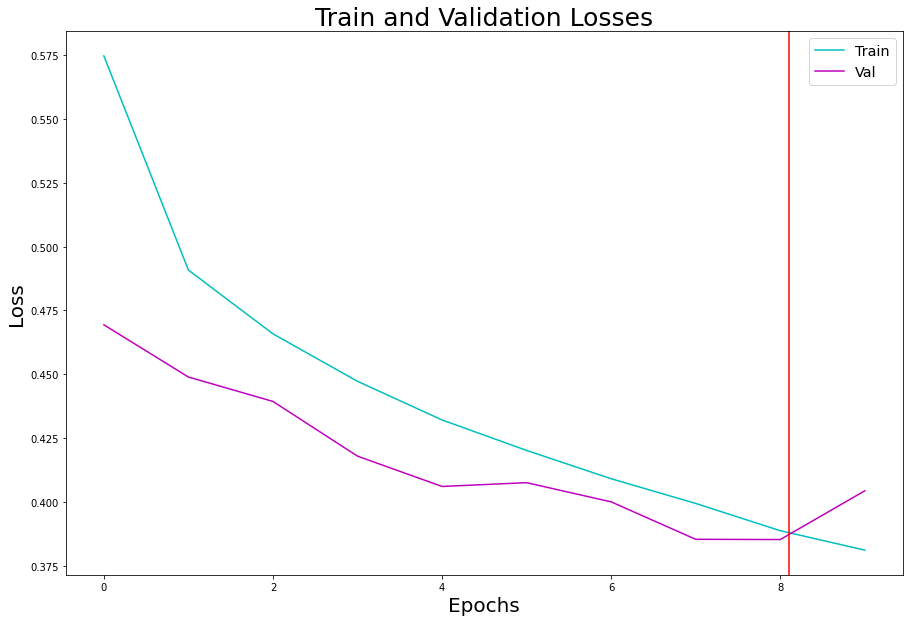

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(15,10))

early_stopping = 8.1

# Plot Train and Validation Losses
axs.set_title("Train and Validation Losses",size=25)
axs.set_ylabel('Loss', fontsize = 20.0) 
axs.set_xlabel('Epochs', fontsize = 20) 
_=axs.plot(train_losses,'-c')
_=axs.plot(val_losses,'-m')  
_=axs.axvline(x=early_stopping,color='r')
_=axs.legend(('Train','Val'),loc='upper right',fontsize='x-large')

> As we can observe after approximately 9th epoch overfitting starts to happen cause training loss keeps falling, but validation loss starts rising up.

### Classification report 

In [ ]:
results = []
true_labels = []

with torch.no_grad():
  for batch in test_iterator:
    for temp_label in batch.Label:
      true_labels.append(temp_label.item())
    for text in batch.Text:
      text = text.unsqueeze(0)
      res, _ = model.forward(text, hidden=None)
      target = np.round(res.cpu().numpy())
      results.append(target[0])
      
print(classification_report(true_labels,results))

              precision    recall  f1-score   support

           0       0.83      0.69      0.75      1219
           1       0.75      0.87      0.80      1281

    accuracy                           0.78      2500
   macro avg       0.79      0.78      0.78      2500
weighted avg       0.79      0.78      0.78      2500



### ROC Curve

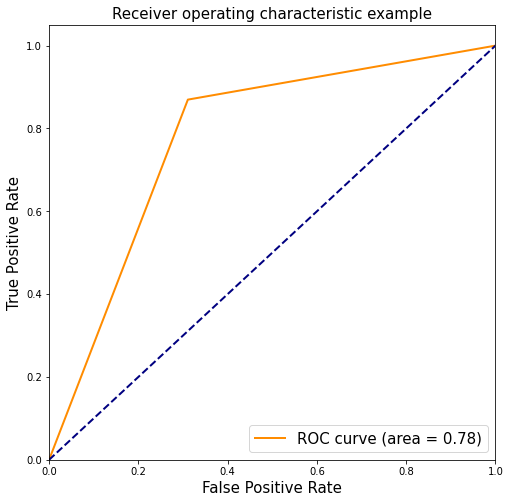

In [ ]:
# Label binarization and store num of classes.
y_score = np.array(results)
y_test = label_binarize(true_labels, classes=[0, 1])
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver operating characteristic example',fontsize=15)
plt.legend(loc="lower right",fontsize=15)
plt.show()

### Our final model's hyperparameters 

> 1. ***LSTM or GRU***

    This was the most difficult choice among our hyperparameters, cause it seemed that LSTM and GRU gave us same 
    results, so they performed well both of them. But finaly we prefered LSTM model and we are gonna explain the reasons 
    later thoroughly!

> 2. ***Bidirectional***
  
    As a project's requirement we created multiple times only bidirectional models! 

> 3. ***Number of Layers***

    We tried different number of stacked layers on our GRU models, in range of  [2,4], but we conclude that a simpler 
    model performs greater so 2 layers was our best choice.

> 4. ***Hidden Size***

    We've been experimented with values in range of [32,512] picking up values which are powers of 2 (2^k). And seems 
    that the magic number for hidden size of GRU model was 128. Note that because we have bidirectional model after LSTM 
    model our Linear layer's hidden size innerly is multiplied by 2.
   
> 5. ***Glove Embedding's Dimensions***

    GloVe pre trained embeddings give us the flexibility to choose whichever dimensions we prefer from a variety of 
    dimensions [25,300]. Due to memory's limit we have to choose something that suits us and finally our choice was 50 
    dimensions for each vector. Note that with GloVe we created a vocabulary with top 20.000 'popular' words, because we 
    observed that we get pretty same results with a vocabulary with all words of our tweets.

> 6. ***Dropout***

    Firstly we put dropout layer inside GRU model and right after GRU model with a small dropout probality equaled to 
    0.2. This helped train and validation loss decrease with same rhythm. 

> 7. ***Optimizer***

    From our theory and so much information out there Adam optimizer was very popular, so it was our stable choice.

> 8. ***Loss Function***

    Also here, cause our problem is binary sentiment classification and due to the fact that our model has a final 
    sigmoid layer, loss function is Binary Cross Entropy Loss.

> 9. ***Epochs***

    Turns out that we only need 5-10 epochs to reach the appropriate result that we aimed to.

> 10. ***Learning Rate***

    The most important hyperparameter was learning rate and after many experiments 2e-3 was pretty descent.
   
   

#### Notes about model's improvement procedure.

    Our mindset was first to experiment with one LSTM bidirectional model and find best hyperparameters. We tried firstly to 
    give us training input dataset of 1.200.000 tweets with split of train and validation/test set with ratio 99%-1%.
    This affected our test's accuracy were we managed to gain around 0.69 score, so we decided to give as input the same 
    number of tweets that we gave in previous best model, which was half of million, which helped us cause our 
    experiments last less. So we found our dataset size, 500.000 tweets.

    After that we tried to find out number of hidden size and number of (stacked) layers on our LSTM model...so we 
    started from 512 hidden size and 6 layers, because from theory we knew that deeper and complex models have more 
    potential to perform better. But in contrast to theory we conclude that our model is too complex and that causes 
    overfitting too much and very bad performance. So we tried firstly to solve that problem of overfitting with adding 
    inside our LSTM model and right after it dropout layers, with dropout probability range from 0.3 to 0.9. But still 
    problem of overfitting was there, even though we add weight regularization parameter in our optimizer. So next step was 
    to make our model less complex so we gradually tried to decrease number of layers and hidden size, so after many 
    experiments we saw that overfitting started to be a past problem.

    So in that point we have locked hidden size to 128 and num of layers 2 (minimum number of layers cause we have 
    bidirectional model). Learning rate was under research cause some times 1e-2 was pretty good, however other times 
    1e-2 was too big so we then change it to 1e-3, until we found that 2e-3 was something like our upper boundary. 
    
    Something pretty important was dropout probability, cause when we tried to experiment with model with dropout at all 
    our model performed worse than when we had a small dropout probability equaled to 0.2, which was our final choice.

    Notice that our final choice of batch size was 512, because with that value we managed to avoid overfitting 
    (cause with small number of batch size, i.e. 32 our model chunked tweets more pieces and was learning much faster, 
    leading to huge undefeated overfitting). As a plus, with batch size be 512 our experiments last less than when we gave
    small values.

    Also, we didn't expect that length of vocabulary of pre trained glove model will affect LSTM model, which is our 
    Embedding's layer input dimension. More specifically it seems that when we didn't use max_size as a parameter, that
    leading to the fact that we gave to embedding layer all words of all tweets (whole information) our model was 
    getting too much information which maybe confused it. On the other hand when we picked our 20.000 most popular words
    with each word have a frequency of at least 5 times, maybe model performed better, cause it had as input an 
    amount of information that could manipulate.

    As a note from theory to avoid vanishing gradients we can use gradient clipping, so I used it in with clip equaled to
    5 and only to be sure I removed it so as to check if it helps model's training and this was for sure true!

    Last but not least, we have to try GRU model instead of LSTM, which are more complex as structure compared to GRUs. 
    As we have already refered GRU and LSTM model with same hyperparameters had same performance, with only difference 
    of them be time of training, where GRU needed half time in each epoch compared to LSTM model. Our theory approves 
    that these two types of RNNs have slight differences, but GRUs are gradually gaining ground due to their simpler 
    structure (compared to LSTMs). Although we finally prefered LSTM model, because learning curves were smoothier in 
    validation and training loss. Note that from theory we expected, that due to different number of gates (2 for GRU 
    and 3 for LSTM), to have different results-performance from these two types of RNNs but didn't come true, which may 
    be due to our tweet dataset.

    After all these experiments, overfitting was avoided until 9th epoch were we 'early stopped' LSTM's training,because 
    validation loss starts rising compared to training loss.

#### Compare our final LSTM model with our previous TfIdf Vectorized best model

    1. Firstly we are going to compare our final LSTM model and our previous TfIdf best model based on their scores on 
    test's dataset. Both models manage to gain a pretty descent score of 0.78 accuracy. Note that in both models train 
    dataset size was half million cleaned tweets.

    2. The big difference between our two models performance is the speed of convergence. More specifically, previous 
    TfIdf best model achieved 0.78 score in 30 epochs, but our new LSTM model made it in only 10 epochs! This fact is due
    to the fact that LSTM model has much more complex structure compared to simple feed forward neural network.

    3. Another difference between our two models is that TfIdf model performed 0.78 accuracy in our 3 metrics (Precision,
    Recall,F1-Score). However, it seems that our LSTM model gained a variety from 0.69 to 0.87. Also ROC curve for TfIdf 
    gave us 0.86, but LSTM achieved only 0.78 score. 

    4. From our theory we expected that our new LSTM model will perform noticeably better than TfIdf model, cause this 
    kind of problems (classification on text or speech data) is often solved with LSTM or GRU models, or generally with 
    RNNs, but this belief didn't come true. But maybe the fact, that our previous model had as input TfIdf vectorized 
    data, with each dimensions of each tweet be 1000 helped our linear layers to have more information leading to 
    descent score. For our LSTM model embedding layer's dimensions was 50.

    5. Some more details about FFNN vs RNN...Let's see firstly about FNNNs!
    FFNNs allow signals to travel one way only: from input to output. There are no feedback, loops...so we conclude that 
    output of any layer does not affect that same layer. Feed-forward ANNs tend to be straightforward networks that 
    associate inputs with outputs. They are extensively used in pattern recognition. This type of organisation is also 
    referred to as bottom-up or top-down.
    RNNs from the other side, and our specific cell type LSTM models can 'travel' to two ways and for that reason we 
    call them interactive or dynamic. So all kinds of RNNs have feedback loops in the recurrent layer and thus maintain 
    information in 'memory' over time. LSTM networks are a type of RNN that uses special units in addition to standard 
    units. LSTM units include a 'memory cell' that can maintain information in memory for long periods of time. A set of 
    gates is used to control when information enters the memory, when it's output, and when it's forgotten. This 
    architecture lets them learn longer-term dependencies. GRUs are similar to LSTMs, but use a simplified structure. 
    They also use a set of gates to control the flow of information, but they don't use separate memory cells, and they
    use fewer gates.

